In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import sys

NB_DIR = os.getcwd()
ROOT_DIR = os.path.dirname(NB_DIR)
sys.path.append(ROOT_DIR)

from cosas.datasets import ScannerData, COSASData
from cosas.paths import DATA_DIR

cosas_data = COSASData(os.path.join(DATA_DIR, "task2"))
cosas_data.load()

COSASData(
  data_dir=/vast/AI_team/dataset/COSAS24-TrainingSet/task2,
  kfbio=ScannerData(data_dir=/vast/AI_team/dataset/COSAS24-TrainingSet/task2/kfbio-400, N images=60, N mask=60
  ddd=ScannerData(data_dir=/vast/AI_team/dataset/COSAS24-TrainingSet/task2/3d-1000, N images=60, N mask=60
  teksqray=ScannerData(data_dir=/vast/AI_team/dataset/COSAS24-TrainingSet/task2/teksqray-600p, N images=60, N mask=60
  Image(n=180)
)

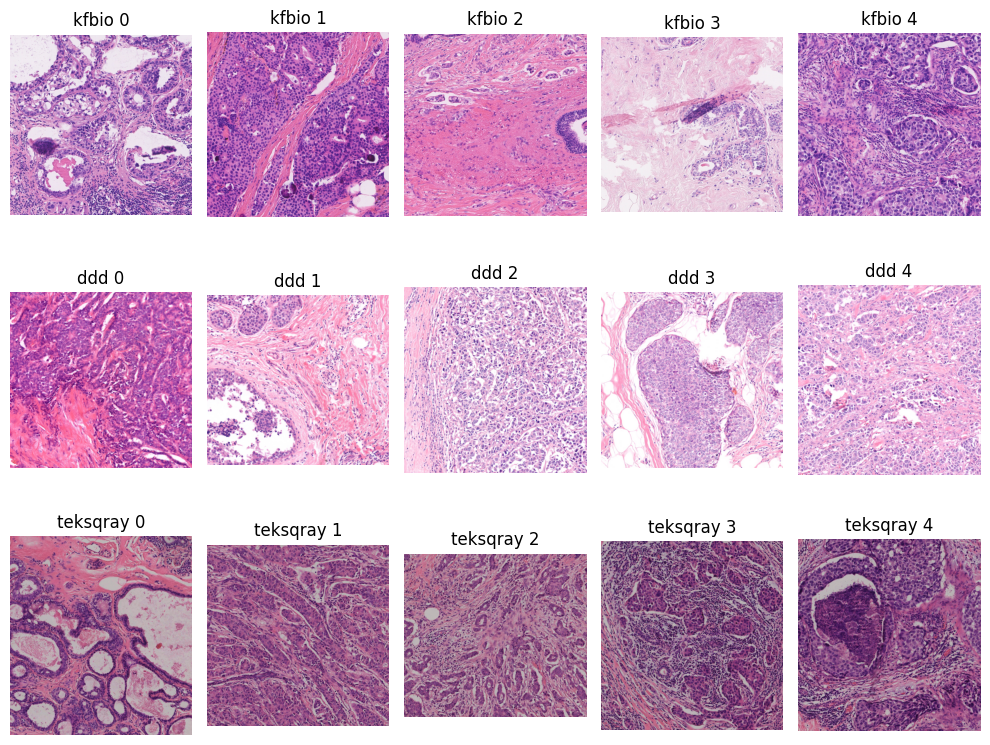

In [7]:
import random
from matplotlib import pyplot as plt
from cosas.datasets import Scanncers

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 8))
for scanner_idx, scanner in enumerate(Scanncers):
    scanner_data: ScannerData = getattr(cosas_data, scanner.name)
    images = random.sample(scanner_data.image, k=5)
    for image_idx, image in enumerate(images):
        ax = axes[scanner_idx, image_idx]
        ax.imshow(image)
        ax.set_title(f"{scanner.name} {image_idx}")
        ax.axis("off")

plt.tight_layout()
plt.show()